# 👪 [Day 20](https://adventofcode.com/2020/day/20)

In [1]:
import numpy as np
from collections import defaultdict

def parse(inputs):
    tiles = {}
    for tile in inputs:
        tile = tile.splitlines()
        if len(tile)== 0: continue
        tile_id = int(tile[0][5:-1])
        tile = np.array([[1 if x == '#' else 0
                          for x in line] 
                         for line in tile[1:]])
        tiles[tile_id] = tile
    return tiles


def collect_borders(tiles):
    # Collect every border of each tile + their flipped 
    # counterparts
    borders = defaultdict(lambda: [])
    for tile_id, tile in tiles.items():
        borders[tuple(tile[0, :])].append(tile_id)
        borders[tuple(tile[0, ::-1])].append(tile_id)
        borders[tuple(tile[-1, :])].append(tile_id)
        borders[tuple(tile[-1, ::-1])].append(tile_id)
        borders[tuple(tile[:, 0])].append(tile_id)
        borders[tuple(tile[::-1, 0])].append(tile_id)
        borders[tuple(tile[:, -1])].append(tile_id)
        borders[tuple(tile[::-1, -1])].append(tile_id)
    return borders


def find_corner_tiles(tiles):
    """Quickly isolates tiles at the corners for Part1"""
    borders = collect_borders(tiles)
    # We know that tiles at the outermost edge won't align with any other tiles
    # thus, tiles at the corners are the only ones that have 2 edges
    # not shared with any one
    # Because we added flipped variants, all the numbers are doubled (
    # if two edges match, they also do match in the flipped version)
    # For all the other tiles they will have > 4 matches
    count_shared_borders = defaultdict(lambda: 0)
    for b, nbs in borders.items():
        if len(nbs) >= 2:
            for n in nbs:
                count_shared_borders[n] += 1
    corners = [x for x, v in count_shared_borders.items() if v == 4]
    assert len(corners) == 4
    return corners[0] * corners[1] * corners[2] * corners[3]

    
def align_tiles(tiles):
    """Guess part1 hack was not enough for part 2 :(, 
    so let's try to solve this alignment..."""
    ### Preliminary
    # First, we use the same logic 
    # as find_corner_tiles to find the corners
    # and build a graph of neighbors node
    borders = collect_borders(tiles)
    count_shared_borders = defaultdict(lambda: 0)
    neighbors = defaultdict(lambda: [])
    for b, nbs in borders.items():
        if len(nbs) >= 2:
            for i, n in enumerate(nbs):
                neighbors[n].extend(nbs[:i] + nbs[i + 1:])
                count_shared_borders[n] += 1
    corners = [x for x, v in count_shared_borders.items() if v == 4]
    neighbors = {k: list(set(v)) for k, v in neighbors.items()}
    del count_shared_borders
    
    ### Placement search
    # Now let's find an alignment using DFS
    # The states will be an assignment of positons in 
    # the square to tile id
    
    ## Initialize
    # We only need to start with one corner, since we can 
    # rotate the image afterwards. 
    # Our initial queue is placing top left corner in different
    # rotations / flip configurations
    queue = []
    n = int(np.sqrt(len(tiles)))
    state = np.zeros((n, n), dtype=np.int32)
    state[0, 0] = corners[0]
    rotations = np.zeros((n, n))
    flips = np.zeros((n, n))
    # Note: 
    # Rotations are done in clockwise
    # Rotate 180 + fliph = same as Rotate 0 + flipv
    # and rotate 0 + fliph = same as rotate 180 + fliph
    # Therefore, given the angle, flip only needs to be a boolean
    # for 0 and 180, flip = True ==> rotate then flip horizontally
    # for 90 and 270, flip = True ==> rotate then flip vertically
    for angle in [0, 90, 180, 270]:
        for flip in [True, False]:
            rotations[0, 0] = angle
            flips[0, 0] = flip
            queue.append((n * n - 1, state, np.array(rotations), np.array(flips), (0, 0)))
            
    ## Search
    # We start by filling position (0, 0) then we iterate
    # in a standard reading order (left to right and top to bottom)
    while len(queue):
        num_left, state, rotations, flips, (x, y) = queue.pop() #heapq.heappop(queue)
        if num_left == 0:
            return state
        
        # Idenitify next tile position and border to be matched
        # 1: If we arrive at the end of row: we need to match the 
        # bottom edge of first tile in the row
        if y == n - 1:
            nxt_x, nxt_y = x + 1, 0
            tile_id, angle, flip = state[x, 0], rotations[x, 0], flips[x, 0]
            if angle == 0:
                border = tiles[tile_id][-1, :]
                if flip:
                    border = border[::-1]
            elif angle == 90:
                if flip: # vertical flip
                    border = tiles[tile_id][::-1, 0]
                else:
                    border = tiles[tile_id][::-1, -1]
            elif angle == 180:
                border = tiles[tile_id][0, ::-1]
                if flip:
                    border = border[::-1]
            else:
                if flip: #  vertical flip
                    border = tiles[tile_id][:, -1]
                else:
                    border = tiles[tile_id][:, 0]
        # 2: Otherwise, we just match the right edge of the latest tile
        else:
            nxt_x, nxt_y = x, y + 1
            tile_id, angle, flip = state[x, y], rotations[x, y], flips[x, y]
            if angle == 0:
                if flip: # horizontal flip
                    border = tiles[tile_id][:, 0]
                else:
                    border = tiles[tile_id][:, -1]
            elif angle == 90:
                border = tiles[tile_id][0, :]
                if flip:
                    border = border[::-1]
            elif angle == 180:
                if flip: # horizontal flip
                    border = tiles[tile_id][::-1, -1]
                else:
                    border = tiles[tile_id][::-1, 0]
            else:
                border = tiles[tile_id][-1, ::-1]
                if flip:
                    border = border[::-1]
                
        # Browse candidates and find the orientation that matches the border
        for nxt_tile_id in neighbors[tile_id]:
            # ignore already placed tiles
            if nxt_tile_id in state:
                continue
            new_rotations = np.array(rotations)
            new_flips = np.array(flips)
            # Fst case : match the bottom edge
            if y == n - 1:
                # Top row matches
                if np.array_equal(tiles[nxt_tile_id][0, :], border):
                    new_rotations[nxt_x, nxt_y] = 0
                    new_flips[nxt_x, nxt_y] = 0
                elif np.array_equal(tiles[nxt_tile_id][0, ::-1], border):
                    new_rotations[nxt_x, nxt_y] = 0
                    new_flips[nxt_x, nxt_y] = 1
                # Right column matches
                elif np.array_equal(tiles[nxt_tile_id][:, -1], border):
                    new_rotations[nxt_x, nxt_y] = 270
                    new_flips[nxt_x, nxt_y] = 0
                elif np.array_equal(tiles[nxt_tile_id][::-1, -1], border):
                    new_rotations[nxt_x, nxt_y] = 90
                    new_flips[nxt_x, nxt_y] = 1
                # Bottom row matches
                elif np.array_equal(tiles[nxt_tile_id][-1, :], border):
                    new_rotations[nxt_x, nxt_y] = 180
                    new_flips[nxt_x, nxt_y] = 1
                elif np.array_equal(tiles[nxt_tile_id][-1, ::-1], border):
                    new_rotations[nxt_x, nxt_y] = 180
                    new_flips[nxt_x, nxt_y] = 0
                # left column matches
                elif np.array_equal(tiles[nxt_tile_id][:, 0], border):
                    new_rotations[nxt_x, nxt_y] = 270
                    new_flips[nxt_x, nxt_y] = 1
                elif np.array_equal(tiles[nxt_tile_id][::-1, 0], border):
                    new_rotations[nxt_x, nxt_y] = 90
                    new_flips[nxt_x, nxt_y] = 0
                else:
                    continue
            # snd case: match the right edge
            else:
                # Top row matches
                if np.array_equal(tiles[nxt_tile_id][0, :], border):
                    new_rotations[nxt_x, nxt_y] = 270
                    new_flips[nxt_x, nxt_y] = 1
                elif np.array_equal(tiles[nxt_tile_id][0, ::-1], border):
                    new_rotations[nxt_x, nxt_y] = 270
                    new_flips[nxt_x, nxt_y] = 0
                # Right column matches
                elif np.array_equal(tiles[nxt_tile_id][:, -1], border):
                    new_rotations[nxt_x, nxt_y] = 0
                    new_flips[nxt_x, nxt_y] = 1
                elif np.array_equal(tiles[nxt_tile_id][::-1, -1], border):
                    new_rotations[nxt_x, nxt_y] = 180
                    new_flips[nxt_x, nxt_y] = 0
                # Bottom row matches
                elif np.array_equal(tiles[nxt_tile_id][-1, :], border):
                    new_rotations[nxt_x, nxt_y] = 90
                    new_flips[nxt_x, nxt_y] = 0
                elif np.array_equal(tiles[nxt_tile_id][-1, ::-1], border):
                    new_rotations[nxt_x, nxt_y] = 90
                    new_flips[nxt_x, nxt_y] = 1
                # left column matches
                elif np.array_equal(tiles[nxt_tile_id][:, 0], border):
                    new_rotations[nxt_x, nxt_y] = 0
                    new_flips[nxt_x, nxt_y] = 0
                elif np.array_equal(tiles[nxt_tile_id][::-1, 0], border):
                    new_rotations[nxt_x, nxt_y] = 180
                    new_flips[nxt_x, nxt_y] = 1
                else:
                    continue
                    
            # Add to the queue and continue
            new_state = np.array(state)
            new_state[nxt_x, nxt_y] = nxt_tile_id
            if num_left == 1:
                return new_state, new_rotations, new_flips
                
            else:
                queue.append((num_left - 1, new_state, 
                                     new_rotations, new_flips, 
                                     (nxt_x, nxt_y)))
    return None
                
    
def display_sea(tiles, state, rotations, flips):
    """Concatenate tiles to form the sea image"""
    d = list(tiles.values())[0].shape[0] - 2
    n = int(np.sqrt(len(tiles)))
    img = np.zeros((n * d, n * d))
    for i in range(n):
        for j in range(n):
            if state[i, j] != 0:
                # Flips and rotation
                t = np.array(tiles[state[i, j]])
                for _ in range(int(rotations[i, j]) // 90):
                    t = np.rot90(t, axes=(1, 0))
                if flips[i, j]:
                    if rotations[i, j] in [0, 180]:
                        t = np.fliplr(t)
                    else:
                        t = np.flipud(t)
                # Placement
                img[i*d:(i + 1)*d, j*d:(j + 1) * d] = t[1:-1, 1:-1]
    return img
    
    
def find_sea_monsters(tiles, verbose=False):
    state, rotations, flips = align_tiles(tiles)
    sea = display_sea(tiles, state, rotations, flips)
    
    # convolution filters
    monster_filter = """                  # 
#    ##    ##    ###
 #  #  #  #  #  #   """
    monster_filter = np.array([[1 if c == '#' else 0 for c in line] 
                               for line in monster_filter.splitlines()])
    monster_size = np.sum(monster_filter)
    
    # Look for monsters using 2D convolutions
    for angle in [0, 90, 180, 270]:
        for flip in [True, False]:
            if angle in [0, 180]:
                sea = np.fliplr(sea)
            else:
                sea = np.flipud(sea)
            num_monsters = 0
            total_sum = np.sum(sea)
            for i in range(monster_filter.shape[0], sea.shape[0] + 1):
                for j in range(monster_filter.shape[1], sea.shape[1] + 1):
                    # Found a monster
                    habitat = sea[i-monster_filter.shape[0]:i, 
                                  j - monster_filter.shape[1]:j]
                    if np.sum(habitat * monster_filter) == monster_size:
                        num_monsters += 1
                        if verbose:
                            sea[i-monster_filter.shape[0]:i, 
                                j - monster_filter.shape[1]:j] -= 2 * monster_filter
            if num_monsters > 0:
                roughness = int(total_sum - num_monsters * monster_size)
                if verbose:
                    from matplotlib import pyplot as plt
                    plt.figure(figsize=(15, 15))
                    plt.imshow(sea, cmap='Blues')
                    plt.title(f'The sea of monsters has a roughness of {roughness}',
                              fontsize=20)
                    plt.axis('off')
                    plt.savefig('viz/day20.png', dpi=300, bbox_inches='tight')
                    plt.show()
                return num_monsters, roughness
        # Rotate
        sea = np.rot90(sea)

The corner tiles' IDS product is 13983397496713.


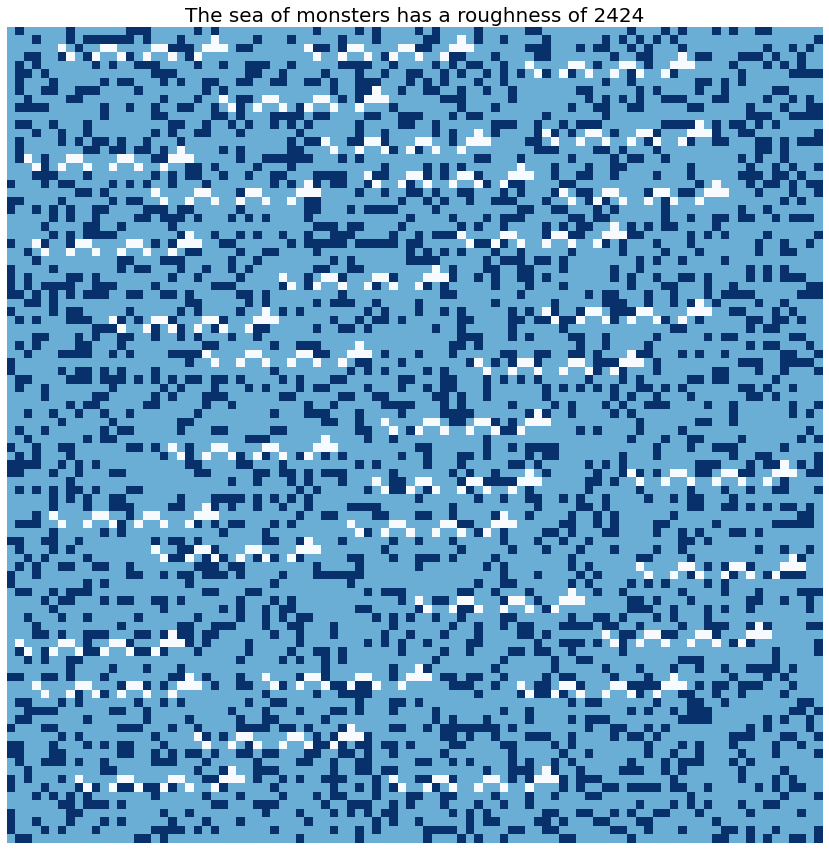

In [2]:
with open('inputs/day20.txt', 'r') as f:
    tiles = parse(f.read().split('\n\n'))

print(f"The corner tiles' IDS product is {find_corner_tiles(tiles)}.")
_ = find_sea_monsters(tiles, verbose=True)